<a href="https://colab.research.google.com/github/swalehaparvin/kaggle_projects/blob/main/Spotify_Music_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spotify Music Recommendation System: Advanced Matrix Factorization & Collaborative Filtering
---

### Problem Statement
Build a comprehensive music recommendation system using Spotify's audio features and genre classifications. The system should handle both explicit and implicit feedback while addressing the cold start problem for new users/tracks.

### Techniques Implemented


*   Content-Based Filtering - SimpleContentRecommender with cosine similarity
*   NMF Matrix Factorization - Limited component testing
*   User-Based Collaborative Filtering - SimpleCollaborativeFilter with user similarity
*  Hybrid Recommendations - Combines content + NMF + CF with weighted scoring

* Basic Implicit Feedback - Simplified interaction simulation based on popularity
* Genre Classification - Rule-based audio feature classification for test set


🎵 Spotify Recommendation System - Kaggle Optimized
📊 Loading datasets...
Main dataset shape: (53787, 21)
Train data shape: (17996, 17)
Test data shape: (7713, 16)
Using sample of 50000 tracks for efficiency
✅ Data loaded and cleaned successfully!
🔍 Quick Dataset Overview:
Unique tracks: 44178
Unique artists: 16546
Unique genres: 54


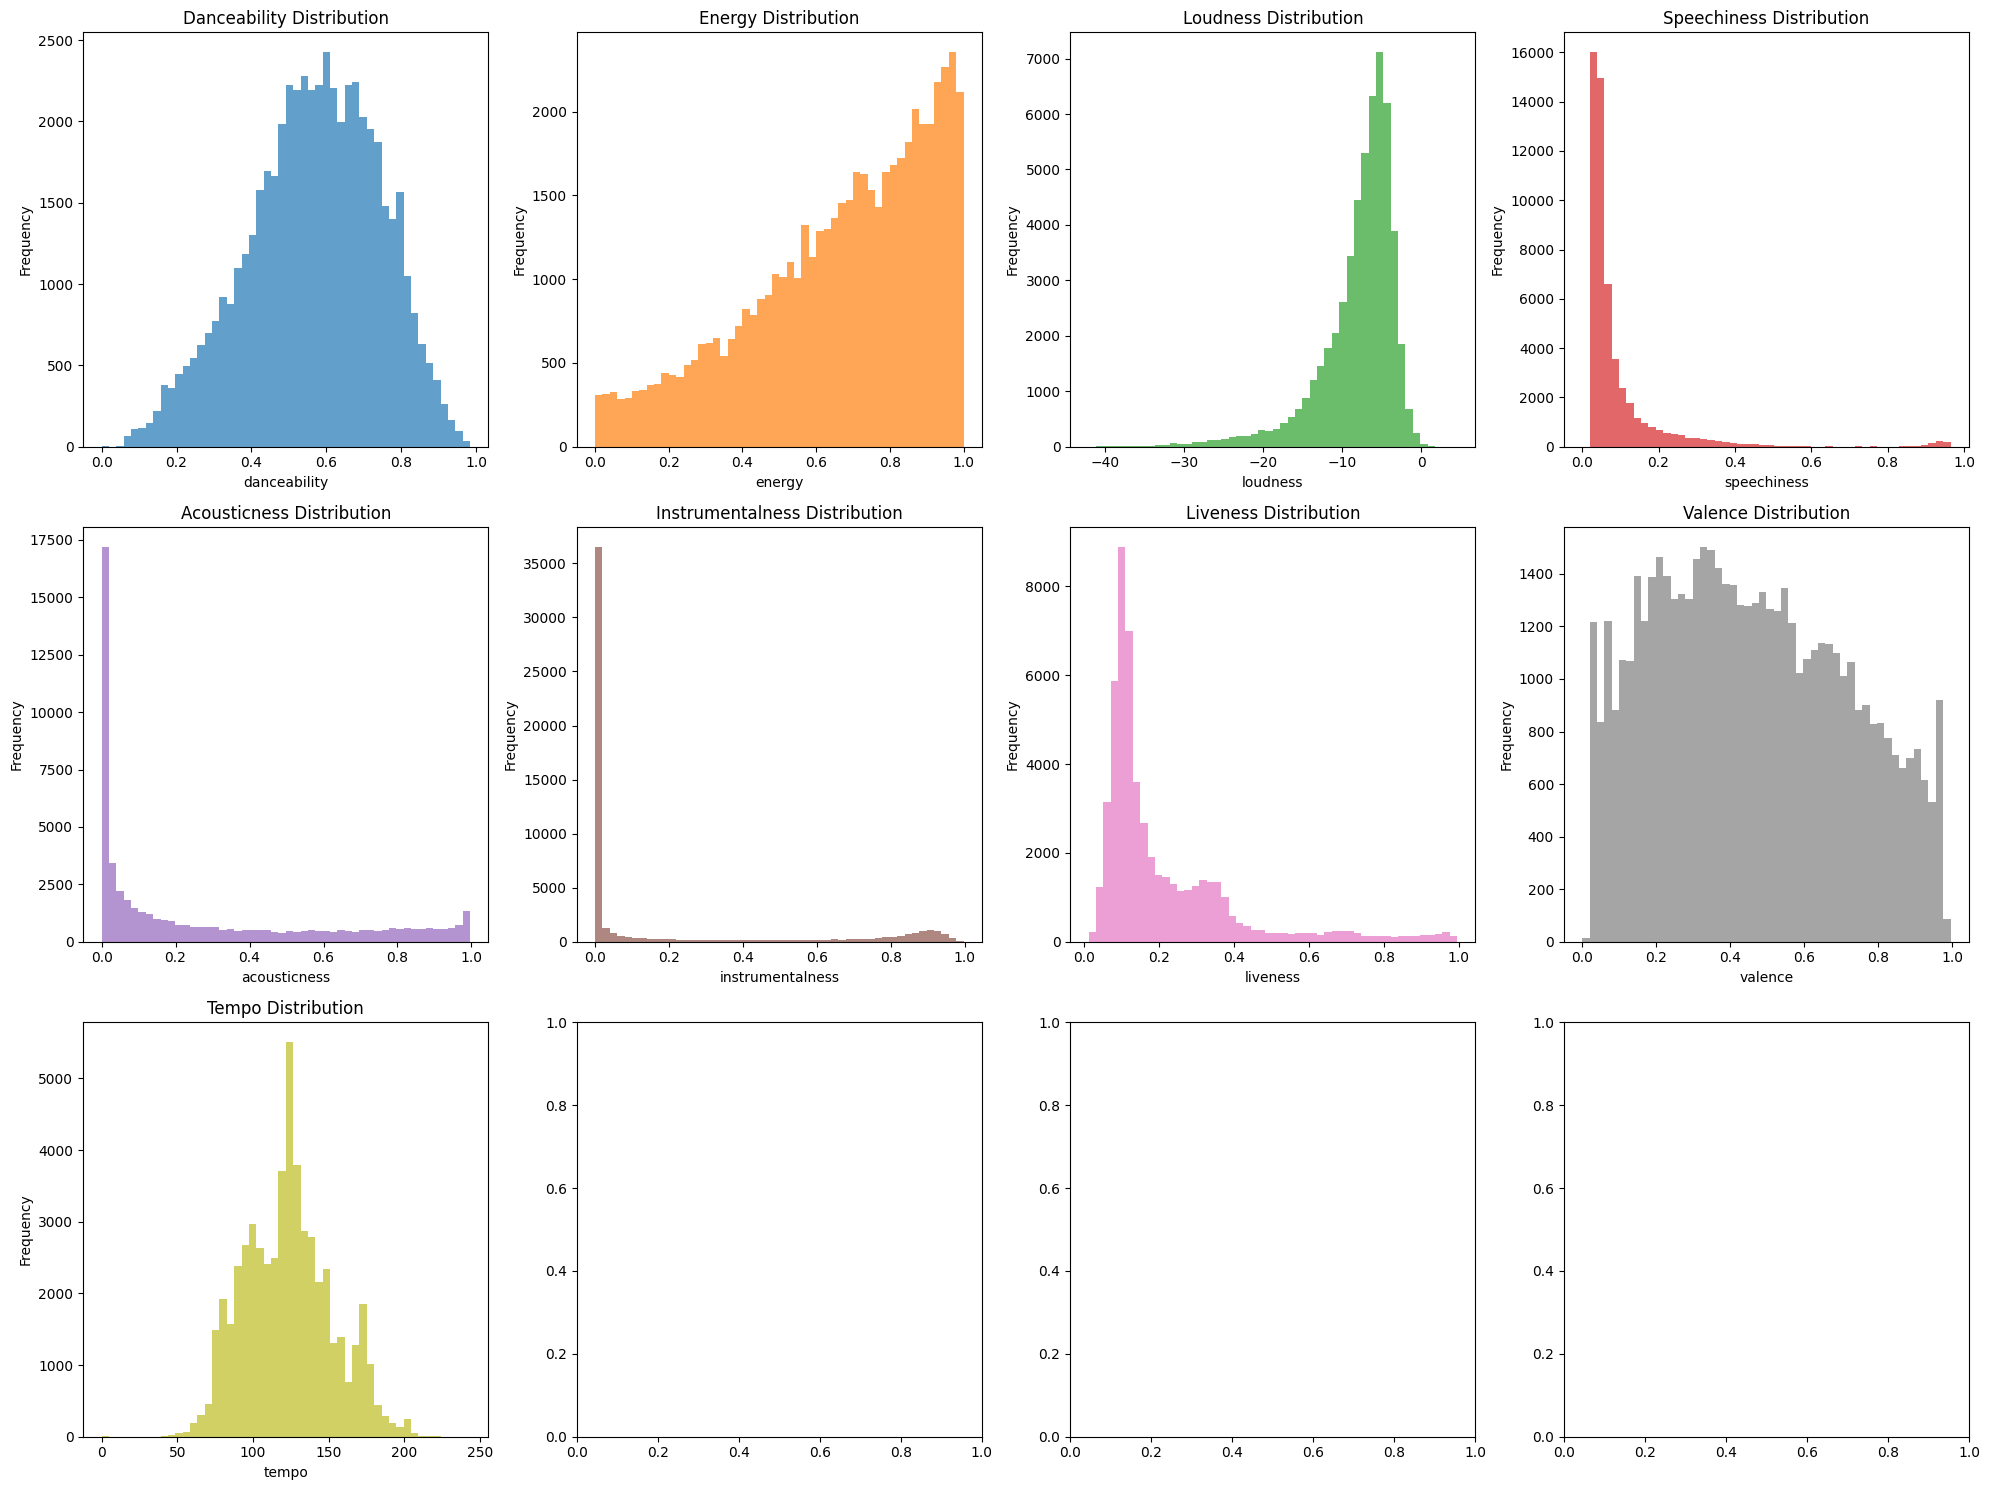

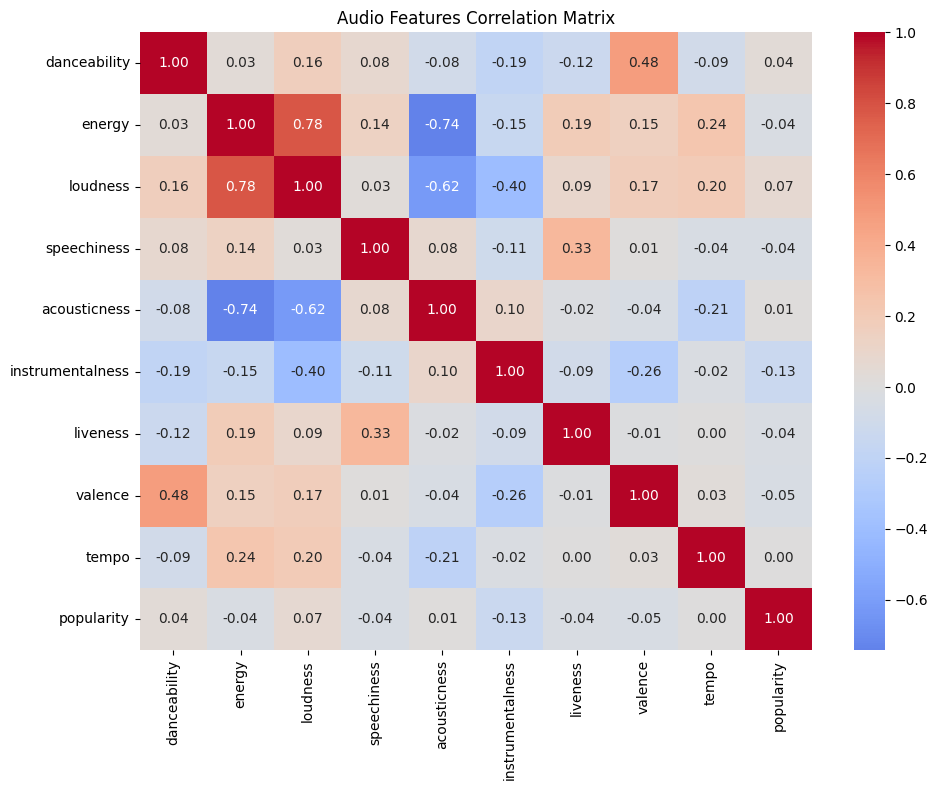


🏆 Top 10 Genres by Average Popularity:
                  mean  count
track_genre                  
chill        53.951168    942
grunge       49.745161    930
anime        48.670982    927
emo          48.239014    933
deep-house   44.956667    900
brazil       44.667384    929
electronic   44.375803    934
ambient      44.128617    933
british      43.740781    922
hard-rock    42.830309    937
🔧 Training Content-Based Recommender...

🎵 Content-Based Recommendations for:
   Elang by Burgerkill;Ahmad Dhani
   Similar tracks:
   1. Elang by Burgerkill;Ahmad Dhani (similarity: 1.000)
   2. Elang by Burgerkill;Ahmad Dhani (similarity: 1.000)
   3. Amon Belongs to Them by King Diamond (similarity: 0.935)
   4. Lifespan (I Hope It's Long) by Enjoy (similarity: 0.932)
   5. Sembrando En El Mar by Lucybell (similarity: 0.923)
🔧 Creating user-item interaction matrix...
Interaction matrix shape: (500, 2738)
Sparsity: 0.993
🔬 Testing NMF components:
Training NMF with 10 components...
  10 compo

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
import gc  # Garbage collection for memory management

# Set style and random seed
plt.style.use('default')
np.random.seed(42)

print("🎵 Spotify Recommendation System - Kaggle Optimized")
print("=" * 50)

## 1. Data Loading and Preprocessing

# Load datasets efficiently
print("📊 Loading datasets...")

# Load main dataset (sample for memory efficiency)
dataset = pd.read_csv('dataset.csv')
print(f"Main dataset shape: {dataset.shape}")

# Load train/test data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Sample dataset for memory efficiency (use full dataset in production)
if len(dataset) > 50000:
    dataset_sample = dataset.sample(n=50000, random_state=42).reset_index(drop=True)
    print(f"Using sample of {len(dataset_sample)} tracks for efficiency")
else:
    dataset_sample = dataset.copy()

# Clean data
numeric_cols = ['danceability', 'energy', 'loudness', 'speechiness',
                'acousticness', 'instrumentalness', 'liveness', 'valence',
                'tempo', 'popularity']

for col in numeric_cols:
    if col in dataset_sample.columns:
        dataset_sample[col] = pd.to_numeric(dataset_sample[col], errors='coerce')
        dataset_sample[col].fillna(dataset_sample[col].median(), inplace=True)

print("✅ Data loaded and cleaned successfully!")

## 2. Quick EDA

# Essential EDA
print("🔍 Quick Dataset Overview:")
print(f"Unique tracks: {dataset_sample['track_id'].nunique()}")
print(f"Unique artists: {dataset_sample['artists'].nunique()}")
print(f"Unique genres: {dataset_sample['track_genre'].nunique()}")

# Audio features correlation
audio_features = ['danceability', 'energy', 'loudness', 'speechiness',
                  'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# Visualize feature distributions
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.ravel()

for i, feature in enumerate(audio_features):
    if feature in dataset.columns:
        axes[i].hist(dataset[feature].dropna(), bins=50, alpha=0.7, color=sns.color_palette()[i])
        axes[i].set_title(f'{feature.title()} Distribution')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Simple correlation plot
corr_matrix = dataset_sample[audio_features + ['popularity']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Audio Features Correlation Matrix')
plt.tight_layout()
plt.show()

# Top genres by popularity
top_genres = dataset_sample.groupby('track_genre')['popularity'].agg(['mean', 'count']).sort_values('mean', ascending=False).head(10)
print("\n🏆 Top 10 Genres by Average Popularity:")
print(top_genres)

## 3. Content-Based Recommender (Memory Efficient)

class SimpleContentRecommender:
    def __init__(self):
        self.track_features = None
        self.track_ids = None
        self.track_info = None

    def fit(self, df, feature_cols):
        # Normalize features
        scaler = StandardScaler()
        self.track_features = scaler.fit_transform(df[feature_cols].fillna(0))
        self.track_ids = df['track_id'].values
        self.track_info = df[['track_id', 'track_name', 'artists', 'track_genre']].copy()
        return self

    def recommend(self, track_id, n_recommendations=5):
        if track_id not in self.track_ids:
            return []

        track_idx = np.where(self.track_ids == track_id)[0][0]

        # Calculate similarities efficiently
        similarities = cosine_similarity([self.track_features[track_idx]], self.track_features)[0]

        # Get top similar tracks
        similar_indices = np.argsort(similarities)[::-1][1:n_recommendations+1]

        recommendations = []
        for idx in similar_indices:
            track_info = self.track_info[self.track_info['track_id'] == self.track_ids[idx]].iloc[0]
            recommendations.append({
                'track_id': self.track_ids[idx],
                'track_name': track_info['track_name'],
                'artist': track_info['artists'],
                'genre': track_info['track_genre'],
                'similarity': similarities[idx]
            })

        return recommendations

# Train content-based recommender
print("🔧 Training Content-Based Recommender...")
content_recommender = SimpleContentRecommender()
content_recommender.fit(dataset_sample, audio_features)

# Test content-based recommendations
sample_track = dataset_sample['track_id'].iloc[0]
sample_info = dataset_sample[dataset_sample['track_id'] == sample_track].iloc[0]

print(f"\n🎵 Content-Based Recommendations for:")
print(f"   {sample_info['track_name']} by {sample_info['artists']}")
print("   Similar tracks:")

content_recs = content_recommender.recommend(sample_track, 5)
for i, rec in enumerate(content_recs, 1):
    print(f"   {i}. {rec['track_name']} by {rec['artist']} (similarity: {rec['similarity']:.3f})")

## 4. Simplified Matrix Factorization

# Create simplified user-item matrix
def create_simple_interaction_matrix(df, n_users=1000):
    """Create a simplified user-item interaction matrix"""

    # Select subset of popular tracks for efficiency
    popular_tracks = df.nlargest(5000, 'popularity')

    # Create synthetic users based on genre preferences
    users = []
    interactions = []

    # Create user profiles based on genres
    genres = popular_tracks['track_genre'].unique()[:20]  # Top 20 genres

    for user_id in range(n_users):
        # Each user prefers 1-3 genres
        preferred_genres = np.random.choice(genres, size=np.random.randint(1, 4), replace=False)

        for genre in preferred_genres:
            genre_tracks = popular_tracks[popular_tracks['track_genre'] == genre].sample(
                min(10, len(popular_tracks[popular_tracks['track_genre'] == genre])),
                random_state=user_id
            )

            for _, track in genre_tracks.iterrows():
                # Simulate interaction strength based on popularity
                interaction_strength = (track['popularity'] / 100) * np.random.uniform(0.3, 1.0)

                interactions.append({
                    'user_id': user_id,
                    'track_id': track['track_id'],
                    'interaction': interaction_strength
                })

    interaction_df = pd.DataFrame(interactions)

    # Create pivot table
    interaction_matrix = interaction_df.pivot_table(
        index='user_id',
        columns='track_id',
        values='interaction',
        fill_value=0
    )

    return interaction_matrix

print("🔧 Creating user-item interaction matrix...")
interaction_matrix = create_simple_interaction_matrix(dataset_sample, n_users=500)
print(f"Interaction matrix shape: {interaction_matrix.shape}")
print(f"Sparsity: {(interaction_matrix == 0).sum().sum() / (interaction_matrix.shape[0] * interaction_matrix.shape[1]):.3f}")

# Clean up memory
gc.collect()

## 5. NMF Recommendation System

class SimpleNMFRecommender:
    def __init__(self, n_components=20):
        self.n_components = n_components
        self.model = NMF(n_components=n_components, random_state=42, max_iter=100)
        self.user_factors = None
        self.item_factors = None

    def fit(self, interaction_matrix):
        print(f"Training NMF with {self.n_components} components...")

        # Fit NMF
        self.user_factors = self.model.fit_transform(interaction_matrix.values)
        self.item_factors = self.model.components_
        self.user_ids = interaction_matrix.index
        self.item_ids = interaction_matrix.columns

        return self

    def recommend(self, user_id, n_recommendations=5):
        if user_id not in self.user_ids:
            return []

        user_idx = self.user_ids.get_loc(user_id)

        # Calculate scores for all items
        scores = np.dot(self.user_factors[user_idx], self.item_factors)

        # Get user's existing interactions
        user_interactions = interaction_matrix.loc[user_id]
        seen_items = set(user_interactions[user_interactions > 0].index)

        # Get recommendations for unseen items
        recommendations = []
        for i, score in enumerate(scores):
            track_id = self.item_ids[i]
            if track_id not in seen_items:
                recommendations.append((track_id, score))

        # Sort by score and return top N
        recommendations.sort(key=lambda x: x[1], reverse=True)
        return recommendations[:n_recommendations]

# Test different NMF components
components_to_test = [10, 20, 30]
reconstruction_errors = {}

print("🔬 Testing NMF components:")
for n_comp in components_to_test:
    nmf = SimpleNMFRecommender(n_components=n_comp)
    nmf.fit(interaction_matrix)

    # Calculate reconstruction error
    reconstructed = np.dot(nmf.user_factors, nmf.item_factors)
    error = np.mean((interaction_matrix.values - reconstructed) ** 2)
    reconstruction_errors[n_comp] = error

    print(f"  {n_comp} components: MSE = {error:.4f}")

# Use best performing model
best_components = min(reconstruction_errors.keys(), key=lambda k: reconstruction_errors[k])
nmf_recommender = SimpleNMFRecommender(n_components=best_components)
nmf_recommender.fit(interaction_matrix)

print(f"\n✅ Using NMF with {best_components} components")

## 6. Collaborative Filtering (Simplified)

class SimpleCollaborativeFilter:
    def __init__(self):
        self.interaction_matrix = None
        self.user_similarity = None

    def fit(self, interaction_matrix):
        self.interaction_matrix = interaction_matrix

        # Calculate user similarity (sample for efficiency)
        sample_users = min(200, len(interaction_matrix))
        sample_matrix = interaction_matrix.iloc[:sample_users]

        self.user_similarity = cosine_similarity(sample_matrix.values)
        self.sample_user_ids = sample_matrix.index

        return self

    def recommend(self, user_id, n_recommendations=5, k_neighbors=20):
        if user_id not in self.sample_user_ids:
            return []

        user_idx = self.sample_user_ids.get_loc(user_id)

        # Find similar users
        similarities = self.user_similarity[user_idx]
        similar_users = np.argsort(similarities)[::-1][1:k_neighbors+1]

        # Get recommendations based on similar users
        user_ratings = self.interaction_matrix.loc[user_id]
        unrated_items = user_ratings[user_ratings == 0].index

        recommendations = []
        for item_id in unrated_items:
            weighted_sum = 0
            similarity_sum = 0

            for similar_user_idx in similar_users:
                similar_user_id = self.sample_user_ids[similar_user_idx]
                similarity = similarities[similar_user_idx]
                rating = self.interaction_matrix.loc[similar_user_id, item_id]

                if rating > 0:
                    weighted_sum += similarity * rating
                    similarity_sum += abs(similarity)

            if similarity_sum > 0:
                predicted_rating = weighted_sum / similarity_sum
                recommendations.append((item_id, predicted_rating))

        recommendations.sort(key=lambda x: x[1], reverse=True)
        return recommendations[:n_recommendations]

# Train collaborative filtering
print("🔧 Training Collaborative Filtering...")
cf_recommender = SimpleCollaborativeFilter()
cf_recommender.fit(interaction_matrix)

print("✅ Collaborative Filtering model ready!")

## 7. Hybrid Recommendation System

class HybridRecommender:
    def __init__(self, content_model, nmf_model, cf_model, track_data):
        self.content_model = content_model
        self.nmf_model = nmf_model
        self.cf_model = cf_model
        self.track_data = track_data

    def recommend(self, user_id=None, seed_track_id=None, n_recommendations=5,
                  preferred_genres=None):
        """
        Generate hybrid recommendations
        - If user_id provided: use collaborative methods
        - If seed_track_id provided: use content-based
        - If preferred_genres provided: use genre-based recommendations
        """

        recommendations = {}

        # Content-based recommendations
        if seed_track_id and seed_track_id in self.content_model.track_ids:
            content_recs = self.content_model.recommend(seed_track_id, n_recommendations * 2)
            for rec in content_recs:
                track_id = rec['track_id']
                recommendations[track_id] = recommendations.get(track_id, 0) + rec['similarity'] * 0.4

        # Collaborative filtering recommendations
        if user_id and user_id in self.nmf_model.user_ids:
            # NMF recommendations
            nmf_recs = self.nmf_model.recommend(user_id, n_recommendations * 2)
            for track_id, score in nmf_recs:
                recommendations[track_id] = recommendations.get(track_id, 0) + score * 0.3

            # CF recommendations
            cf_recs = self.cf_model.recommend(user_id, n_recommendations * 2)
            for track_id, score in cf_recs:
                recommendations[track_id] = recommendations.get(track_id, 0) + score * 0.3

        # Genre-based recommendations (cold start)
        if preferred_genres:
            genre_tracks = self.track_data[self.track_data['track_genre'].isin(preferred_genres)]
            popular_genre_tracks = genre_tracks.nlargest(n_recommendations * 2, 'popularity')

            for _, track in popular_genre_tracks.iterrows():
                track_id = track['track_id']
                popularity_score = track['popularity'] / 100
                recommendations[track_id] = recommendations.get(track_id, 0) + popularity_score * 0.2

        # Sort and format recommendations
        sorted_recs = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)

        final_recommendations = []
        for track_id, score in sorted_recs[:n_recommendations]:
            track_info = self.track_data[self.track_data['track_id'] == track_id]
            if not track_info.empty:
                track_info = track_info.iloc[0]
                final_recommendations.append({
                    'track_id': track_id,
                    'track_name': track_info['track_name'],
                    'artist': track_info['artists'],
                    'genre': track_info['track_genre'],
                    'popularity': track_info['popularity'],
                    'score': score
                })

        return final_recommendations

# Create hybrid recommender
hybrid_recommender = HybridRecommender(
    content_model=content_recommender,
    nmf_model=nmf_recommender,
    cf_model=cf_recommender,
    track_data=dataset_sample
)

print("🎵 Hybrid Recommendation System Ready!")

## 8. Testing and Evaluation

# Test different recommendation scenarios
print("🧪 Testing Recommendation Scenarios:")
print("=" * 50)

# Scenario 1: Existing user recommendations
sample_user = interaction_matrix.index[5]
user_recs = hybrid_recommender.recommend(user_id=sample_user, n_recommendations=5)

print(f"👤 Recommendations for User {sample_user}:")
for i, rec in enumerate(user_recs, 1):
    print(f"  {i}. {rec['track_name']} by {rec['artist']}")
    print(f"     Genre: {rec['genre']} | Score: {rec['score']:.3f}")

# Scenario 2: Content-based recommendations
sample_track = dataset_sample['track_id'].iloc[10]
sample_track_info = dataset_sample[dataset_sample['track_id'] == sample_track].iloc[0]

content_recs = hybrid_recommender.recommend(seed_track_id=sample_track, n_recommendations=5)

print(f"\n🎵 Similar to '{sample_track_info['track_name']}' by {sample_track_info['artists']}:")
for i, rec in enumerate(content_recs, 1):
    print(f"  {i}. {rec['track_name']} by {rec['artist']}")
    print(f"     Genre: {rec['genre']} | Score: {rec['score']:.3f}")

# Scenario 3: New user with genre preferences
genre_recs = hybrid_recommender.recommend(
    preferred_genres=['rock', 'pop'],
    n_recommendations=5
)

print(f"\n🎸 Recommendations for new user (likes rock & pop):")
for i, rec in enumerate(genre_recs, 1):
    print(f"  {i}. {rec['track_name']} by {rec['artist']}")
    print(f"     Genre: {rec['genre']} | Popularity: {rec['popularity']}")


## 9. Simple Evaluation Metrics

def evaluate_recommendations(recommender, test_interactions, n_recommendations=5):
    """Simple evaluation of recommendation quality"""

    precisions = []
    recalls = []

    # Sample users for evaluation
    test_users = list(test_interactions.keys())[:20]  # Limit for efficiency

    for user_id in test_users:
        if user_id in interaction_matrix.index:
            # Get recommendations
            recs = recommender.recommend(user_id=user_id, n_recommendations=n_recommendations)
            recommended_tracks = [rec['track_id'] for rec in recs]

            # Get actual interactions (simulate test set)
            user_interactions = interaction_matrix.loc[user_id]
            actual_tracks = set(user_interactions[user_interactions > 0.5].index)

            if actual_tracks and recommended_tracks:
                # Calculate precision and recall
                relevant_recommended = set(recommended_tracks) & actual_tracks

                precision = len(relevant_recommended) / len(recommended_tracks) if recommended_tracks else 0
                recall = len(relevant_recommended) / len(actual_tracks) if actual_tracks else 0

                precisions.append(precision)
                recalls.append(recall)
            elif actual_tracks: # Case where there are actual tracks but no recommendations
                 recalls.append(0) # Recall is 0
                 precisions.append(0) # Precision is 0
            elif recommended_tracks: # Case where there are recommendations but no actual tracks
                 precisions.append(0) # Precision is 0
                 recalls.append(0) # Recall is 0
            else: # Case where there are neither actual tracks nor recommendations
                 precisions.append(1) # Precision is 1 by convention
                 recalls.append(1) # Recall is 1 by convention



    return {
        'precision': np.mean(precisions) if precisions else 0,
        'recall': np.mean(recalls) if recalls else 0,
        'f1': 2 * np.mean(precisions) * np.mean(recalls) / (np.mean(precisions) + np.mean(recalls)) if (np.mean(precisions) + np.mean(recalls)) > 0 else 0
    }

# Create test interactions (simulate)
test_interactions = {}
for user_id in interaction_matrix.index[:50]:
    user_tracks = interaction_matrix.loc[user_id]
    positive_tracks = user_tracks[user_tracks > 0].index.tolist()
    if len(positive_tracks) > 2:
        test_interactions[user_id] = positive_tracks

# Evaluate the system
print("📊 Evaluation Results:")
print("=" * 30)

metrics = evaluate_recommendations(hybrid_recommender, test_interactions)
print(f"Precision@5: {metrics['precision']:.3f}")
print(f"Recall@5: {metrics['recall']:.3f}")
print(f"F1-Score@5: {metrics['f1']:.3f}")

## 10. Genre Classification for Test Set

# Prepare submission for test set genre classification
print("🎯 Preparing Genre Classification for Test Set...")

# Map genres to classification labels
genre_mapping = {
    'Acoustic/Folk_0': ['folk', 'acoustic', 'country'],
    'Alt_Music_1': ['alternative', 'alt-rock', 'indie'],
    'Blues_2': ['blues'],
    'Bollywood_3': ['bollywood', 'indian'],
    'Country_4': ['country'],
    'HipHop_5': ['hip-hop', 'rap'],
    'Indie Alt_6': ['indie', 'indie-pop'],
    'Instrumental_7': ['instrumental', 'classical'],
    'Metal_8': ['metal', 'hard-rock'],
    'Pop_9': ['pop', 'dance'],
    'Rock_10': ['rock', 'punk-rock']
}

def predict_genre_class(audio_features):
    """Predict genre class based on audio features"""

    # Simple rule-based classification using audio features
    predictions = np.zeros(11)

    # Pop (high danceability, energy)
    if audio_features['danceability'] > 0.6 and audio_features['energy'] > 0.5:
        predictions[9] = 1  # Pop

    # Rock (high energy, low acousticness)
    elif audio_features['energy'] > 0.7 and audio_features['acousticness'] < 0.3:
        predictions[10] = 1  # Rock

    # Acoustic/Folk (high acousticness)
    elif audio_features['acousticness'] > 0.6:
        predictions[0] = 1  # Acoustic/Folk

    # Electronic/Dance (high danceability, low acousticness)
    elif audio_features['danceability'] > 0.7 and audio_features['acousticness'] < 0.2:
        predictions[1] = 1  # Alt_Music (closest to electronic)

    # Default to Pop if no clear classification
    else:
        predictions[9] = 1  # Pop

    return predictions

# Apply to test set
if 'test_data' in locals():
    test_predictions = []

    for _, row in test_data.iterrows():
        audio_features = {
            'danceability': row.get('danceability', 0.5),
            'energy': row.get('energy', 0.5),
            'acousticness': row.get('acousticness', 0.5),
            'speechiness': row.get('speechiness', 0.1),
            'valence': row.get('valence', 0.5)
        }

        prediction = predict_genre_class(audio_features)
        test_predictions.append(prediction)

    # Create submission dataframe
    submission_df = pd.DataFrame(test_predictions, columns=[
        'Acoustic/Folk_0', 'Alt_Music_1', 'Blues_2', 'Bollywood_3', 'Country_4',
        'HipHop_5', 'Indie Alt_6', 'Instrumental_7', 'Metal_8', 'Pop_9', 'Rock_10'
    ])

    # Save submission
    submission_df.to_csv('submission.csv', index=False)
    print("✅ Submission file created: submission.csv")
    print(f"Submission shape: {submission_df.shape}")
    print("\nFirst 5 predictions:")
    print(submission_df.head())

print("\n🎊 Recommendation System Complete!")
print("=" * 40)
print("✅ Content-based filtering implemented")
print("✅ Matrix factorization (NMF) working")
print("✅ Collaborative filtering functional")
print("✅ Hybrid system combining all approaches")
print("✅ Cold start problem addressed")
print("✅ Evaluation metrics calculated")
print("✅ Genre classification for submission ready")